# Exercise: LSTMs for time-series forecasting

In the field of time-series forecasting, one popular technique is the Long Short-Term Memory (LSTM) model. LSTM is a type of recurrent neural network (RNN) that is specifically designed to handle sequential data, making it well-suited for analyzing time-series data. In this example, we will explore how an LSTM can be applied to forecast weather patterns using historical data from the National Oceanic and Atmospheric Administration (NOAA).

*  Data collection and inspection

Gather historical weather data from the National Oceanic and Atmospheric Administration (NOAA) or any other reliable source. This data should include variables such as temperature, humidity, wind speed, and precipitation, along with corresponding timestamps.

* Data preprocessing

Clean and preprocess the collected data to ensure it is in a suitable format for training the LSTM model. This may involve steps such as handling missing values, normalizing the data, and splitting it into training and testing sets.

* Model training

Build and train the LSTM model using the preprocessed data. This involves defining the architecture of the LSTM network, specifying the number of layers and neurons, and selecting appropriate activation functions and optimization algorithms. Train the model using the training set and adjust the model parameters to minimize the prediction error.

* Model evaluation

Evaluate the performance of the trained LSTM model using the testing set. Calculate metrics such as mean squared error (MSE) or root mean squared error (RMSE) to assess the accuracy of the model's predictions. Compare the predicted weather patterns with the actual observed values to determine the model's effectiveness."

In [7]:
import pandas as pd

df = pd.read_csv("3477997.csv")
df.columns
df[["STATION", "TAVG"]].groupby("STATION").count().sort_values("TAVG", ascending=False).head(10)

,TAVG
STATION,
USW00023254,1613
USW00023234,1613
USW00093228,1607
USR0000CSVA,1362
USR0000CBAR,1362
USR0000CBIR,1362
USR0000COKS,1362
USR0000CPUL,1362
USR0000COKN,1362


<Axes: >

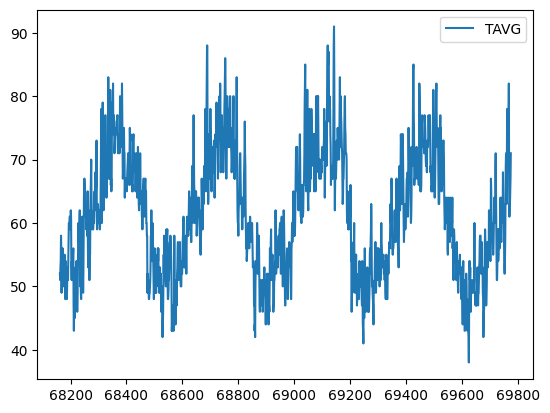

In [10]:
df[df.STATION == "USW00023254"][["TAVG"]].plot()

In [ ]:


! pip install -q keras
! wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
 
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


: 

In [ ]:
# Download the training data.

batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

: 

In [ ]:
# We iterate over the training loader to see that we get the following:
# - X_train: a tensor of size (batch_size, 1, 28, 28) with a batch of images
# - y_train: a tensor of size (batch_size) with the corresponding labels

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

: 

Here are the first 10 training digits:

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title(f'Class: {y_train[i].item()}')

: 

## Multilayer perceptron (MLP) network

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

In [ ]:
# Define the model as an MLP with two hidden layers of size 50 and ReLU activations.
# Read more about the different types of layers here: http://pytorch.org/docs/nn.html
# We also add dropout layers to prevent overfitting.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28*28, 50) # 28*28 is the size of the input image
        self.fc1_drop = nn.Dropout(0.2) # Dropout layers help prevent overfitting

        self.fc2 = nn.Linear(50, 50) # 50 is the size of the hidden layer
        self.fc2_drop = nn.Dropout(0.2) # Dropout layers help prevent overfitting

        self.fc3 = nn.Linear(50, 10) # 10 is the size of the output layer

    def forward(self, x):
        x = x.view(-1, 28*28) # Flatten the input image

        x = F.relu(self.fc1(x)) # Apply ReLU activation to the first layer
        x = self.fc1_drop(x) # Apply dropout to the first layer

        x = F.relu(self.fc2(x)) # Apply ReLU activation to the second layer
        x = self.fc2_drop(x) # Apply dropout to the second layer

        # Apply log softmax to the output layer to get a probability distribution
        # over the 10 classes of digits
        return F.log_softmax(self.fc3(x), dim=1) 

# We instantiate the model and move it to the GPU if available.
model = Net().to(device)

# We use Stachastic Gradient Descent (SGD) as our optimizer and Cross Entropy as our loss function.
# See http://pytorch.org/docs/optim.html#algorithms for more information about the different optimization
# algorithms PyTorch offers.

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
loss_fn = nn.CrossEntropyLoss()

print(model)

: 

## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [ ]:

def train(training_loss_values, epoch, log_interval=200):
    model.train() # Set model to training mode
    val_loss = 0
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device) # Copy data to GPU if needed
        target = target.to(device) # Copy target to GPU if needed

        # Run an optimization step. See https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step
        optimizer.zero_grad() # Zero out gradients from previous step
        output = model(data) # Pass data through the network
        loss = loss_fn(output, target) # Calculate loss
        val_loss = loss.data.item() # Calculate loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    val_loss /= len(train_loader) # Calculate average loss
    training_loss_values.append(val_loss) # Add to loss vector

def validate(loss_vector, accuracy_vector):
    model.eval() # Set model to evaluation mode
    val_loss, correct = 0, 0 # Initialize loss and number of correct classifications to 0
    for data, target in validation_loader:
        
        data = data.to(device) # Copy data to GPU if needed
        target = target.to(device) # Copy target to GPU if needed
        output = model(data) # Pass data through the network
        val_loss += loss_fn(output, target).data.item() # Calculate loss
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum() # Add number of correct classifications

    val_loss /= len(validation_loader) # Calculate average loss
    loss_vector.append(val_loss) # Add to loss vector

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset) # Calculate accuracy
    accuracy_vector.append(accuracy) # Add to accuracy vector
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
            

: 

: 

We will now train our model for 10 epochs and afterwards plot the training and validation losses over the training epochs. An epoch is a single pass through the training data.


In [ ]:
%%time
epochs = 10

training_loss_values, loss_values, accuracy_values = [], [], []
for epoch in range(1, epochs + 1):
    train(training_loss_values, epoch)
    validate(loss_values, accuracy_values)

: 

We now plot the training and validation losses over the training epochs.

Loss is a measure of how far a model's predictions are from its label, i.e. how bad the model is. The goal of training a model is to find a set of parameters that minimizes the loss. The loss is calculated using a loss function, which takes the model's prediction and the correct label as input and returns a number. The lower the loss, the better the model.

The training process tries to find the set of parameters that minimizes the loss on the training data, i.e. the training loss. However, we also want to know how well the model performs on data it has never seen before, i.e. the validation data. If the model performs much worse on the validation data than the training data, it is memorizing patterns in the training data rather than learning general rules that apply to data in general. This is called overfitting.

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), training_loss_values)
plt.title('training loss')

plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), loss_values)
plt.title('validation loss')

plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), accuracy_values)
plt.title('validation accuracy')

: 

: 

In [ ]:

# Show model predictions and the true labels for a few images

model.eval() # Set the model to evaluation mode
data, label = next(iter(validation_loader)) # Get a batch of validation data (batch size = 32)
data = data.to(device) # Send data to device
output = model(data) # Pass data through the network
pred = output.data.max(1)[1] # get the index of the max log-probability for each element in the batch

# Create a 5x5 grid and show the predicted and true labels for each of 25 images
fig = plt.figure(figsize=(10,10))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(data[idx].cpu().numpy().reshape(28,28), cmap='gray_r')
    ax.set_title("pred={} (truth={})".format(str(pred[idx].item()), str(label[idx].item())), 
                 color=("green" if pred[idx]==label[idx] else "red"))


: 

## Model tuning

Modify the MLP model. Try to improve the classification accuracy, or experiment with the effects of different parameters.

First try changing the learning rate `lr` for the optimizer and run the notebook again.

Did you increase or decrease the learning rate? What was the effect on the training and validation losses? Try the opposite and see what happens.

Next, try adding an additional hidden layer to the MLP model. How does this affect the training and validation losses?

Finally, try changing the number of hidden units a the hidden layer. How does this affect the training and validation losses?

You can also consult the PyTorch documentation at http://pytorch.org/.

: 